In [1]:
import os
import networkx as nx
import numpy as np
os.chdir("../")

### Graph verification and preprocessing

In [2]:
import pickle
def load_graph(fn):
    with open(fn, "rb") as f:
        return pickle.load(f)
filenames = [fn for fn in os.listdir("graphs/") if ".pkl" in fn]
graphs = [load_graph("graphs/"+fn) for fn in filenames]

In [3]:
import biograph.constants
index_amino = {code3:i for i, code3 in enumerate(biograph.constants.AMINOACIDS_3)}
index_amino["UNK"] = len(index_amino)
num_amino = len(index_amino)

# Features are aminoacid type, bfactor and x,y,z coord.
all_features = []
for graph in graphs:
    features = np.zeros((graph.number_of_nodes(), num_amino + 4))
    for i, node_idx in enumerate(graph.nodes):
        node = graph.nodes[node_idx]
        #features[i, 0:num_amino+4] = 1
        features[i, index_amino[node["resname"]]] = 1
        features[i, num_amino] = node["bfactor"]
        features[i, num_amino+1:num_amino+4] = node["coord"]
    all_features.append(features)

/home/joaquintz/.local/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


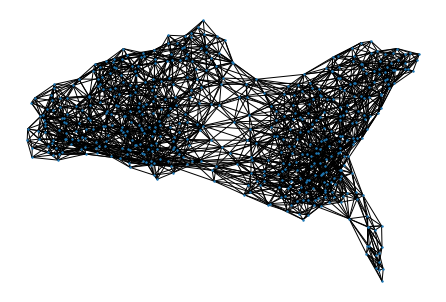

In [50]:
nx.draw(graphs[0], node_size=2, data=False)

In [53]:
graphs[0].nodes[165]

{'full_id': ('2BBT', 0, 'A', (' ', 581, ' '), ('CA', ' ')),
 'depth': 0,
 'bfactor': 31.48,
 'resname': 'LEU',
 'coord': array([ -0.238,  25.985, 108.763], dtype=float32),
 'distance': 22.46042251586914,
 'chain': '2BBT_A'}

In [51]:
nx.write_edgelist(graphs[0], "proteina.edgelist", data=False)

In [4]:
node["bfactor"], *(node["coord"].tolist())

(23.78, 38.2869987487793, 8.71399974822998, 9.73799991607666)

In [5]:
features[-1, :]

array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  1.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        , 23.78      , 38.28699875,  8.71399975,  9.73799992])

In [6]:
all_adj = [nx.adjacency_matrix(graph) for graph in graphs]

In [7]:
def touches_ligand(x):
    return x <= 4 or (x<=6 and np.random.binomial(1, 1-(x-4)/2) == 1)

class_balance = []
all_targets = []
for graph in graphs:
    targets = np.zeros((graph.number_of_nodes(), 2))
    for i, node_idx in enumerate(graph.nodes):
        distance = graph.nodes[node_idx]["distance"]
        targets[i, 0] = 1 if touches_ligand(distance) else 0
        targets[i, 1] = 1 - targets[i, 0]
    class_balance.append(targets[:, 0].sum() / targets[:, 1].sum())
    all_targets.append(targets)

In [8]:
fair_positive_weight = 1/(sum(class_balance)/len(class_balance))
print("For every non-contact point there are {} contact points".format(
    sum(class_balance)/len(class_balance)))
fair_positive_weight

For every non-contact point there are 0.03517511666151417 contact points


28.429187872292715

In [9]:
918002 * sum(class_balance)/len(class_balance)

32290.82744550333

#buggyG = load_graph("graphs/4DX2.pkl")
buggyG = load_graph("graphs/5EXY.pkl")
distances = []
for node_idx in buggyG.nodes:
    distances.append(buggyG.nodes[node_idx]["distance"])
sorted(distances)

In [10]:
filenames[54]

'5ZXD.pkl'

In [11]:
#Check errors
pdb_error_list = []
for i,target in enumerate(all_targets):
    if target[:,0].sum() < 1.0:
        print("Error found in target #{}".format(i))
        pdb_error_list.append((i,filenames[i]))

Error found in target #381
Error found in target #418
Error found in target #910
Error found in target #964
Error found in target #1048
Error found in target #1096
Error found in target #1111
Error found in target #1121


In [12]:
pdb_error_list

[(381, '6FVF.pkl'),
 (418, '4OIP.pkl'),
 (910, '4Q5S.pkl'),
 (964, '2C01.pkl'),
 (1048, '2NYJ.pkl'),
 (1096, '5EXY.pkl'),
 (1111, '2OH5.pkl'),
 (1121, '6ERN.pkl')]

## Example model

In [13]:
import scipy.sparse as sp
import gcn.utils
import gcn.models
import time
import tensorflow as tf
from tensorflow.python import debug as tf_debug

Instructions for updating:
non-resource variables are not supported in the long term


/usr/local/lib/python3.6/dist-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorboard/compat/tensorflow_stub/dtypes.py:544: FutureWa

### Data splits and preprocessing

In [14]:
all_adj = [gcn.utils.sparse_to_tuple(gcn.utils.normalize_adj(adj)) 
            for adj in all_adj]
all_features = [gcn.utils.preprocess_features(sp.lil_matrix(features))
            for features in all_features]

nb_nodes_per_graph = [adj[2][1] for adj in all_adj]
nb_nodes = max(map(lambda adj: adj[2][1], all_adj))
nb_nodes

/home/joaquintz/research/thesis/gcn/utils.py:115: RuntimeWarning: divide by zero encountered in power
  r_inv = np.power(rowsum, -1).flatten()


5840

In [15]:
# Make sparse matrices the same size
for i, adj_tuple in enumerate(all_adj):
    #adj_tuple[2] is the shape, and we want it to be always the same..
    all_adj[i] = (adj_tuple[0], adj_tuple[1], (nb_nodes, nb_nodes))

for i, feat_tuple in enumerate(all_features):
    #adj_tuple[2] is the shape, and we want it to be always the same..
    all_features[i] = (feat_tuple[0], feat_tuple[1], (nb_nodes, feat_tuple[2][1]))

    
for i, target in enumerate(all_targets):
    padded = np.zeros((nb_nodes, 2))
    padded[:target.shape[0], 1] = target[:, 0]
    padded[:target.shape[0], 0] = 1 - target[:, 0]
    all_targets[i] = padded

In [16]:
totes = target.sum(axis=0)

for target in all_targets:
    totes += target.sum(axis=0)
    
totes

array([1016900.,   26396.])

In [17]:
def split_list(data, train_perc, val_perc):
    num_train = int(len(data) * train_perc)
    num_val = int(len(data) * val_perc)
    return data[:num_train], data[num_train:num_train+num_val], data[num_train+num_val:]

features_train, features_val, features_test = split_list(all_features, 0.70, 0.15)
adj_train, adj_val, adj_test = split_list(all_adj, 0.70, 0.15)
y_train, y_val, y_test = split_list(all_targets, 0.70, 0.15)
nodes_train, nodes_val, nodes_test = split_list(nb_nodes_per_graph, 0.70, 0.15)

In [18]:
#flags = tf.app.flags
#flags.DEFINE_float("learning_rate", 0.01, "Learning Rate")
#flags.DEFINE_integer("epochs", 200, "Epochs")
#flags.DEFINE_integer("hidden1", 16, "Num units in HL1")
#flags.DEFINE_float("dropout", 0.5, "Dropout")
#flags.DEFINE_float("weight_decay", 5e-4, "Weight decay")
#flags.DEFINE_integer("early_stopping", 10, "Tolerance")
#flags.DEFINE_integer("max_degree", 3, "Max chebyshev polynomial degree")
#flags.sys.argv = flags.sys.argv[0:1]

In [19]:
from importlib import reload
reload(gcn.inits)
reload(gcn.utils)
reload(gcn.models)

<module 'gcn.models' from '/home/joaquintz/research/thesis/gcn/models.py'>

In [20]:
placeholders = {
    "support": [tf.compat.v1.sparse_placeholder(tf.float32, name="support")],
    "features": tf.compat.v1.sparse_placeholder(tf.float32, 
        #shape=tf.constant(features_train[0][2], dtype=tf.int64, name="feat_shape_const"),
        name="features"),
    "labels": tf.compat.v1.placeholder(tf.float32, shape=(nb_nodes, 2), name="labels"),
    "labels_mask": tf.compat.v1.placeholder(tf.int32, name="labels_mask"),
    "dropout": tf.compat.v1.placeholder_with_default(0., shape=(), name="dropout"),
    "num_features_nonzero": tf.compat.v1.placeholder(tf.int32, name="nfn0")
}


In [21]:
fair_positive_weight_ = fair_positive_weight
fair_positive_weight_

28.429187872292715

In [22]:
class BalancedGCN(gcn.models.GCN):
    def _accuracy(self):
        self.binary_mask = tf.cast(
                tf.compat.v1.math.greater(self.placeholders["labels_mask"], 0),
                dtype=tf.compat.v1.float32)
        self.accuracy = tf.compat.v1.metrics.auc(
            tf.compat.v1.argmax(self.placeholders['labels'], 1),
            tf.compat.v1.argmax(self.outputs, 1), 
            self.placeholders['labels_mask']
        )
        self.conf = tf.compat.v1.math.confusion_matrix(
            labels=tf.compat.v1.argmax(self.placeholders['labels'], 1),
            predictions=tf.compat.v1.argmax(self.outputs, 1),
            num_classes=2,
            weights=self.binary_mask
        )

#model = gcn.models.GCN(placeholders, input_dim=features_train[0][2][1], logging=True)
model = BalancedGCN(placeholders, input_dim=features_train[0][2][1], logging=True)
#sess = tf.compat.v1.Session()
#sess = tf_debug.LocalCLIDebugWrapperSession(sess)
#sess.run(tf.compat.v1.global_variables_initializer())
#sess.run(tf.compat.v1.local_variables_initializer())

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

Instructions for updating:
The value of AUC returned by this may race with the update so this is deprected. Please use tf.keras.metrics.AUC instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


In [23]:
tf.compat.v1.random_uniform

<function tensorflow.python.ops.random_ops.random_uniform(shape, minval=0, maxval=None, dtype=tf.float32, seed=None, name=None)>

In [24]:
%load_ext tensorboard

In [25]:
def make_mask(max_nodes, nodes):
    mask = np.ones((max_nodes))
    mask[nodes:] = 0
    return mask
def train_graph(nodes, adj, features, y, placeholders, 
                fair_positive_weight=fair_positive_weight, nb_nodes=nb_nodes):
    """Optimize model on one instance of a graph"""
    train_mask = make_mask(nb_nodes, nodes)
    train_mask[y[:,1] > 0] = fair_positive_weight # add weight to positive class
    feed_dict = gcn.utils.construct_feed_dict(
        features, [adj], y, train_mask, placeholders)
    feed_dict.update({placeholders['dropout']: FLAGS.dropout})
    outs = sess.run([model.opt_op, model.loss, model.accuracy], feed_dict=feed_dict)
    return outs[1], outs[2][1]

def evaluate(nodes, adj, features, y, placeholders, 
             fair_positive_weight=fair_positive_weight, nb_nodes=nb_nodes):
    """Evaluate the model on a given graph"""
    mask = make_mask(nb_nodes, nodes)
    mask[y[:,1] > 0] = fair_positive_weight # add weight to positive class
    t_test = time.time()
    feed_dict_val = gcn.utils.construct_feed_dict(features, [adj], labels, val_mask,
                                                  placeholders)
    outs_val = sess.run([model.loss, model.accuracy, model.conf], feed_dict=feed_dict_val)
    return outs_val[0], outs_val[1], (time.time() - t_test), outs_val[2]

In [26]:
import datetime
current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
train_log_dir = 'logs/gradient_tape/' + current_time + '/train'
test_log_dir = 'logs/gradient_tape/' + current_time + '/test'
train_summary_writer = tf.summary.create_file_writer(train_log_dir)
test_summary_writer = tf.summary.create_file_writer(test_log_dir)

In [27]:
print(fair_positive_weight)
FLAGS = flags.FLAGS
for epoch in range(FLAGS.epochs):
    # Train step
    train_loss, train_acc = (0,0)
    # Iterate over each training graph
    for i, features in enumerate(features_train):
        it_loss, it_acc = train_graph(nodes_train[i], adj_train[i],
                                      features, y_train[i], placeholders)
        train_loss_total += it_loss
        train_acc_total += it_acc

    train_loss = train_loss/i
    train_acc = train_acc/i
    
    with train_summary_writer.as_default():
        tf.summary.scalar('loss', train_loss, step=epoch)
        tf.summary.scalar('accuracy', train_acc, step=epoch)

    # Validation step
    val_loss, val_acc, val_conf = (0,0, np.zeros(2,2))
    for i, features in enumerate(features_val):
        loss, acc, duration, conf = evaluate(nodes_val[i], adj_val[i], 
                                             features, y_val[i], placeholders)
        conf_total += conf
        val_loss_total += loss
        val_acc_total += acc[1]
    val_loss = val_loss_total/i
    val_acc = val_acc_total/i
    with test_summary_writer.as_default():
        tf.summary.scalar('loss', val_loss, step=epoch)
        tf.summary.scalar('accuracy', val_acc, step=epoch)
    print(conf_total, np.round(conf_total.T/conf_total.sum(axis=1), 2).T)
    print("Epoch: {}, train_loss={:.5f} train_acc={:.5f} \
val_loss={:.5f} val_acc={:.5f}".format(epoch+1, train_loss, train_acc,
                                              val_loss, val_acc))

    if epoch > FLAGS.early_stopping and cost_val[-1] > np.mean(cost_val[-(FLAGS.early_stopping+1):-1]):
        print("Early stopping...")
        break

28.429187872292715


NameError: name 'flags' is not defined

In [ ]:
val_tots = y_val[0].sum(axis=0)
for y_ in y_val:
    val_tots += y_.sum(axis=0)
val_tots -= y_val[0].sum(axis=0)
val_tots

In [37]:
model.layers[0].vars

{'weights_0': <tf.Variable 'balancedgcn/graphconvolution_1_vars/weights_0:0' shape=(25, 16) dtype=float32_ref>}

In [36]:
model.layers[1].vars

{'weights_0': <tf.Variable 'balancedgcn/graphconvolution_2_vars/weights_0:0' shape=(16, 2) dtype=float32_ref>}

In [40]:
features_train[0]

(array([[  0,  24],
        [  0,  23],
        [  0,  22],
        ...,
        [506,  22],
        [506,  21],
        [506,  10]], dtype=int32),
 array([ 0.65131445,  0.15560812, -0.00142524, ...,  0.05662464,
         0.24171919,  0.00691219]),
 (5840, 25))

In [42]:
len(features_train)

859